# HSSM Tutorial Winterbrain 2025
### Nadja R. Ging-Jehli
#### Brown University
#### LNCC Lab (Michael J. Frank)


This is a slightly simplified version of the original workshop tutorial which you can find [here](https://github.com/gingjehli/HSSM/blob/main/HSSMtutorial_Winterbrain_light3.ipynb).

### Load Modules

In [69]:
# Import modules
import arviz as az
import jax
import matplotlib as plt
import pytensor

import hssm

pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)

plt.use("Agg")
%matplotlib inline
%config InlineBackend.figure_format='retina'

hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## 1. Overview of Sequential Sampling Models

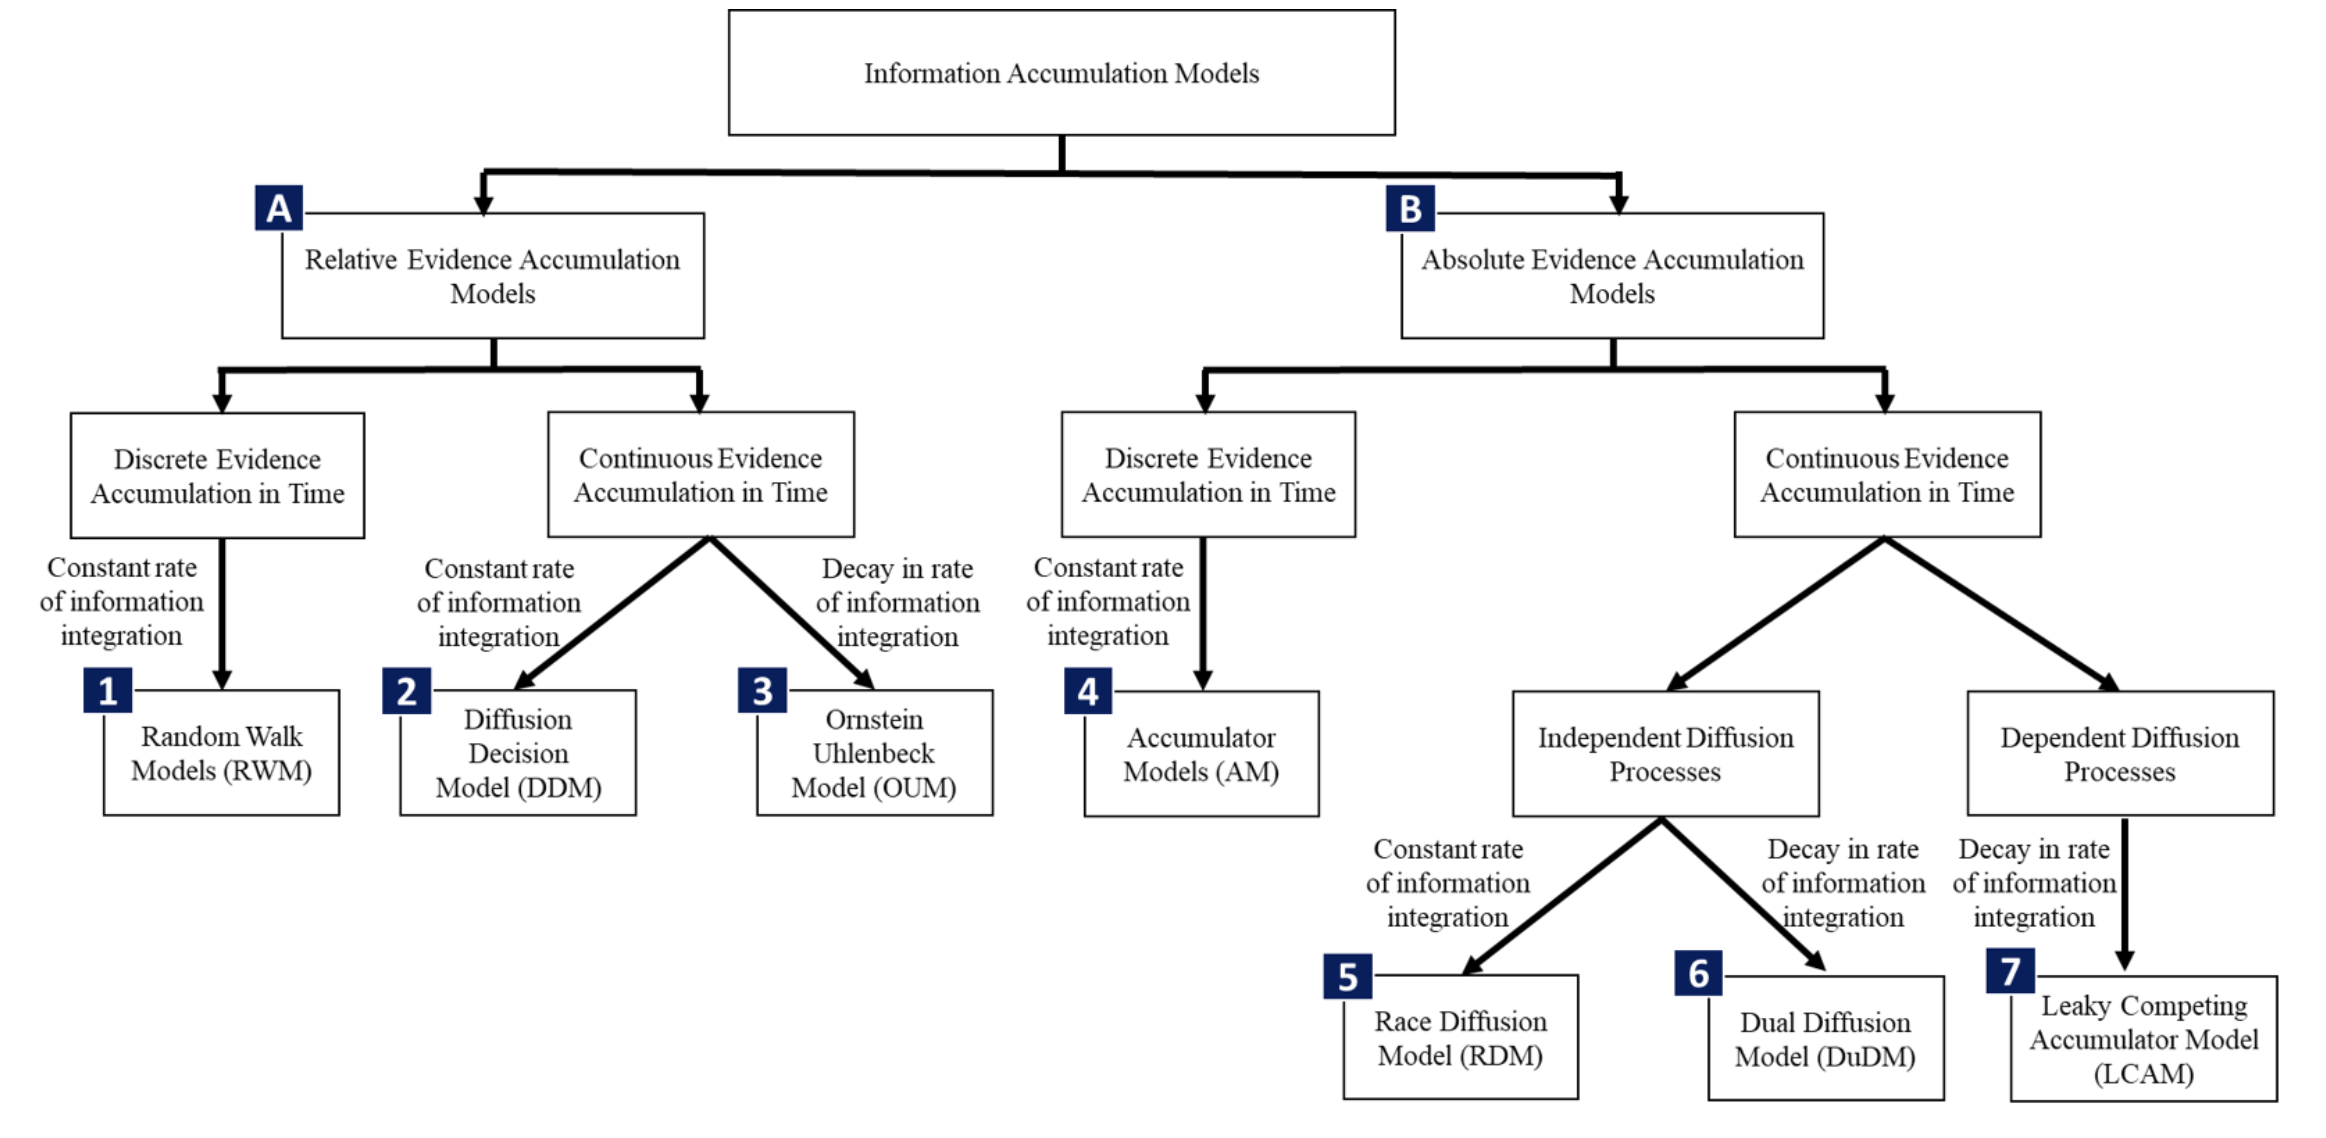

In [70]:
from IPython.display import Image

# Display the image
Image(filename="hssm_tutorial_workshop_1/ssm_overview.png")

### Some Useful Papers relevant for Neuroscience (a small selection)
- [Ratcliff, R., & Frank, M. J. (2012). Reinforcement-based decision making in corticostriatal circuits: mutual constraints by neurocomputational and diffusion models. Neural computation, 24(5), 1186-1229.](https://pubmed.ncbi.nlm.nih.gov/22295983/)
  
- [Turner, B. M., Palestro, J. J., Miletić, S., & Forstmann, B. U. (2019). Advances in techniques for imposing reciprocity in brain-behavior relations. Neuroscience & Biobehavioral Reviews, 102, 327-336.](https://pubmed.ncbi.nlm.nih.gov/31128445/)

- [Forstmann, B. U., Ratcliff, R., & Wagenmakers, E. J. (2016). Sequential sampling models in cognitive neuroscience: Advantages, applications, and extensions. Annual review of psychology, 67(1), 641-666.](https://pmc.ncbi.nlm.nih.gov/articles/PMC5112760/)

### Blogs (self-plug :))
https://www.gingjehli.com/research-blog

In [71]:
### Check supported models
hssm.defaults.SupportedModels

typing.Literal['ddm', 'ddm_sdv', 'full_ddm', 'angle', 'levy', 'ornstein', 'weibull', 'race_no_bias_angle_4', 'ddm_seq2_no_bias', 'lba3', 'lba2']

In [72]:
### Details about a particular model
hssm.defaults.default_model_config["weibull"]
##### the bounds within "likelihoods" provide reasonable parameter values (take this with a grain of salt)

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't', 'alpha', 'beta'],
 'choices': [-1, 1],
 'description': None,
 'likelihoods': {'approx_differentiable': {'loglik': 'weibull.onnx',
   'backend': 'jax',
   'default_priors': {},
   'bounds': {'v': (-2.5, 2.5),
    'a': (0.3, 2.5),
    'z': (0.2, 0.8),
    't': (0.001, 2.0),
    'alpha': (0.31, 4.99),
    'beta': (0.31, 6.99)},
   'extra_fields': None}}}

In [73]:
hssm.defaults.default_model_config["ddm"]

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't'],
 'choices': [-1, 1],
 'description': 'The Drift Diffusion Model (DDM)',
 'likelihoods': {'analytical': {'loglik': <function hssm.likelihoods.analytical.logp_ddm(data: numpy.ndarray, v: float, a: float, z: float, t: float, err: float = 1e-15, k_terms: int = 20, epsilon: float = 1e-15) -> numpy.ndarray>,
   'backend': None,
   'bounds': {'v': (-inf, inf),
    'a': (0.0, inf),
    'z': (0.0, 1.0),
    't': (0.0, inf)},
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'extra_fields': None},
  'approx_differentiable': {'loglik': 'ddm.onnx',
   'backend': 'jax',
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'bounds': {'v': (-3.0, 3.0),
    'a': (0.3, 2.5),
    'z': (0.0, 1.0),
    't': (0.0, 2.0)},
   'extra_fields': None},
  'blackbox': {'loglik': <function hssm.likelihoods.blackbox.hddm_to_hssm.<locals>.outer(data: numpy.ndarray, *args, **kwargs)>,
   'backend': None,
   'bound

#### Notes
- there is a difference between "ddm" and "full_ddm"
- the bounds within "likelihoods" provide reasonable param values (but take this with a grain of salt)
- the order of "list_params" is important

## 2. Regression-based modeling 

### Case Study 1: 1 hierarchical layer (trial-level) with 1 within-subject coefficient)
- you have intracranial recording in STN and want to understand the decision-relevant dynamics in the activity
- we assume that activity in STN varies on a trial-by-trial basis in a systematic way
- your Hypothesis: STN is implicated in response cautiousness
- you want to test this hypothesis using a classical DDM
#### Question to audience: which model parameter does STN modulate?

#### Step 1: Regression-based data simulation (one subjects)

In [74]:
import numpy as np
import pandas as pd
from ssms.basic_simulators.simulator import simulator

v_true = 0.5
a_true = 1.5
z_true = 0.5
t_true = 0.5
# a changes trial wise
# a_trialwise = np.random.normal(loc=2, scale=0.3, size=1000)
Intercept = 1.5
zSTN = np.random.normal(loc=1, scale=1, size=1000).astype(np.float32)
a_trialwise = Intercept + 0.5 * zSTN

# a changes trial wise
theta_mat = np.zeros((1000, 4))
theta_mat[:, 0] = v_true  # v
theta_mat[:, 1] = a_trialwise  # a
theta_mat[:, 2] = z_true  # z
theta_mat[:, 3] = t_true  # t

# simulate data
sim_out_trialwise = simulator(
    theta=theta_mat,  # parameter_matrix
    model="ddm",  # specify model (many are included in ssms)
    n_samples=1,  # number of samples for each set of parameters
    # (plays the role of `size` parameter in `hssm.simulate_data`)
)

# Turn into nice dataset
df_ddm_reg_case1 = pd.DataFrame(
    np.column_stack(
        [sim_out_trialwise["rts"][:, 0], sim_out_trialwise["choices"][:, 0]]
    ),
    columns=["rt", "response"],
)

df_ddm_reg_case1["zSTN"] = zSTN
df_ddm_reg_case1

rt  response      zSTN
0     2.337352       1.0 -0.557265
1     3.005860       1.0  0.928339
2     1.733934       1.0  0.308642
3     1.857290       1.0  0.352734
4     2.558753      -1.0  1.138395
..         ...       ...       ...
995   2.165475       1.0  2.408830
996   4.439553       1.0  0.351558
997   1.401433       1.0  2.409043
998   3.524226       1.0  1.129747
999  16.383413       1.0  2.785511

[1000 rows x 3 columns]

#### Looking at the data, what do you notice?

#### Required Data Structure for HSSM
- we need variables labeled as "rt" and "response"
- make sure rt are in seconds
- responses are (1,-1) because you are in a classical DDM setting
- make sure regressors are z-scored (particularly important when you have more than two regressors)

#### Step 2: Model Setup & Priors

In [75]:
model_ddm_reg_case1 = hssm.HSSM(
    data=df_ddm_reg_case1,
    model="ddm",
    include=[
        {
            "name": "a",
            "formula": "a ~ 1 + zSTN",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 1.0},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 1.0},
            },
            "link": "identity",
        }
    ],
)

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + zSTN
    Priors:
        a_Intercept ~ Normal(mu: 1.5, sigma: 1.0)
        a_zSTN ~ Normal(mu: 0.0, sigma: 1.0)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

##### Notes to Step 2
- make sure your priors are reasonable (always double-check)
- see my blog for useful notes for defining priors on each of these params 
https://www.gingjehli.com/single-post/choosing-effective-samplers-and-setting-priors
- priors are particularly important in these more complex regression-based models
-  it can also be helpful to set "init_val" for the sampler so it starts in a reasonable region. 

#### Step 3: Double-check model specification

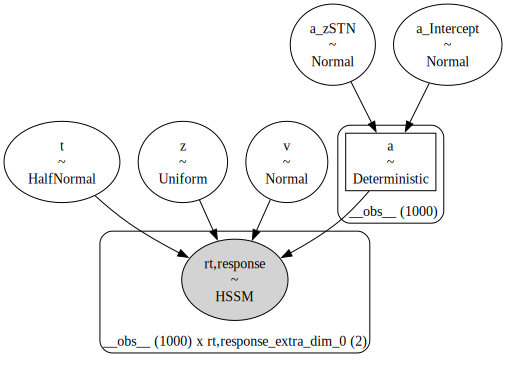

In [76]:
# graphical illustration of model
model_ddm_reg_case1.graph()

#### Step 4: Sampling from the Posterior Distribution

In [77]:
# suppress warnings
import warnings

warnings.filterwarnings("ignore")
samples_model_ddm_reg_case1 = model_ddm_reg_case1.sample(
    sampler="nuts_numpyro",
    cores=2,
    chains=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1000/1000 [00:00<00:00, 2582.16it/s]


##### Notes to Step 4
- in a real analysis, you would want to run more chains (usually >=4)
- if models don't converge, as a first step, it is typically a good idea to increase the chain length
- depending on task structure, some model params are more/less likely to trade-off (e.g., simple task design, `t` & `a` are often anti-correlated)
- if there are parameter trade-offs or depending on your regression equation, it can be helpful to play around with the sampler
- though: nuts_numpyro sampler does not work with blackbox likelihoods.
- sometime variational inference (VI) can be a helpful alternative to MCMC (check out the dedicated tutorials in the HSSM documentation)

#### Step 5: Model Validation

##### What do you think about these results below (also given Jensen's part)?

In [78]:
#### quick check on posterior statistics
model_ddm_reg_case1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t            0.508  0.021   0.470    0.547      0.001    0.001     722.0   
z            0.507  0.014   0.479    0.532      0.001    0.000     492.0   
a_zSTN       0.518  0.022   0.476    0.558      0.001    0.001     658.0   
a_Intercept  1.516  0.033   1.456    1.577      0.001    0.001     751.0   
v            0.546  0.028   0.493    0.598      0.001    0.001     651.0   

             ess_tail  r_hat  
t               541.0    1.0  
z               583.0    1.0  
a_zSTN          722.0    1.0  
a_Intercept     864.0    1.0  
v               547.0    1.0

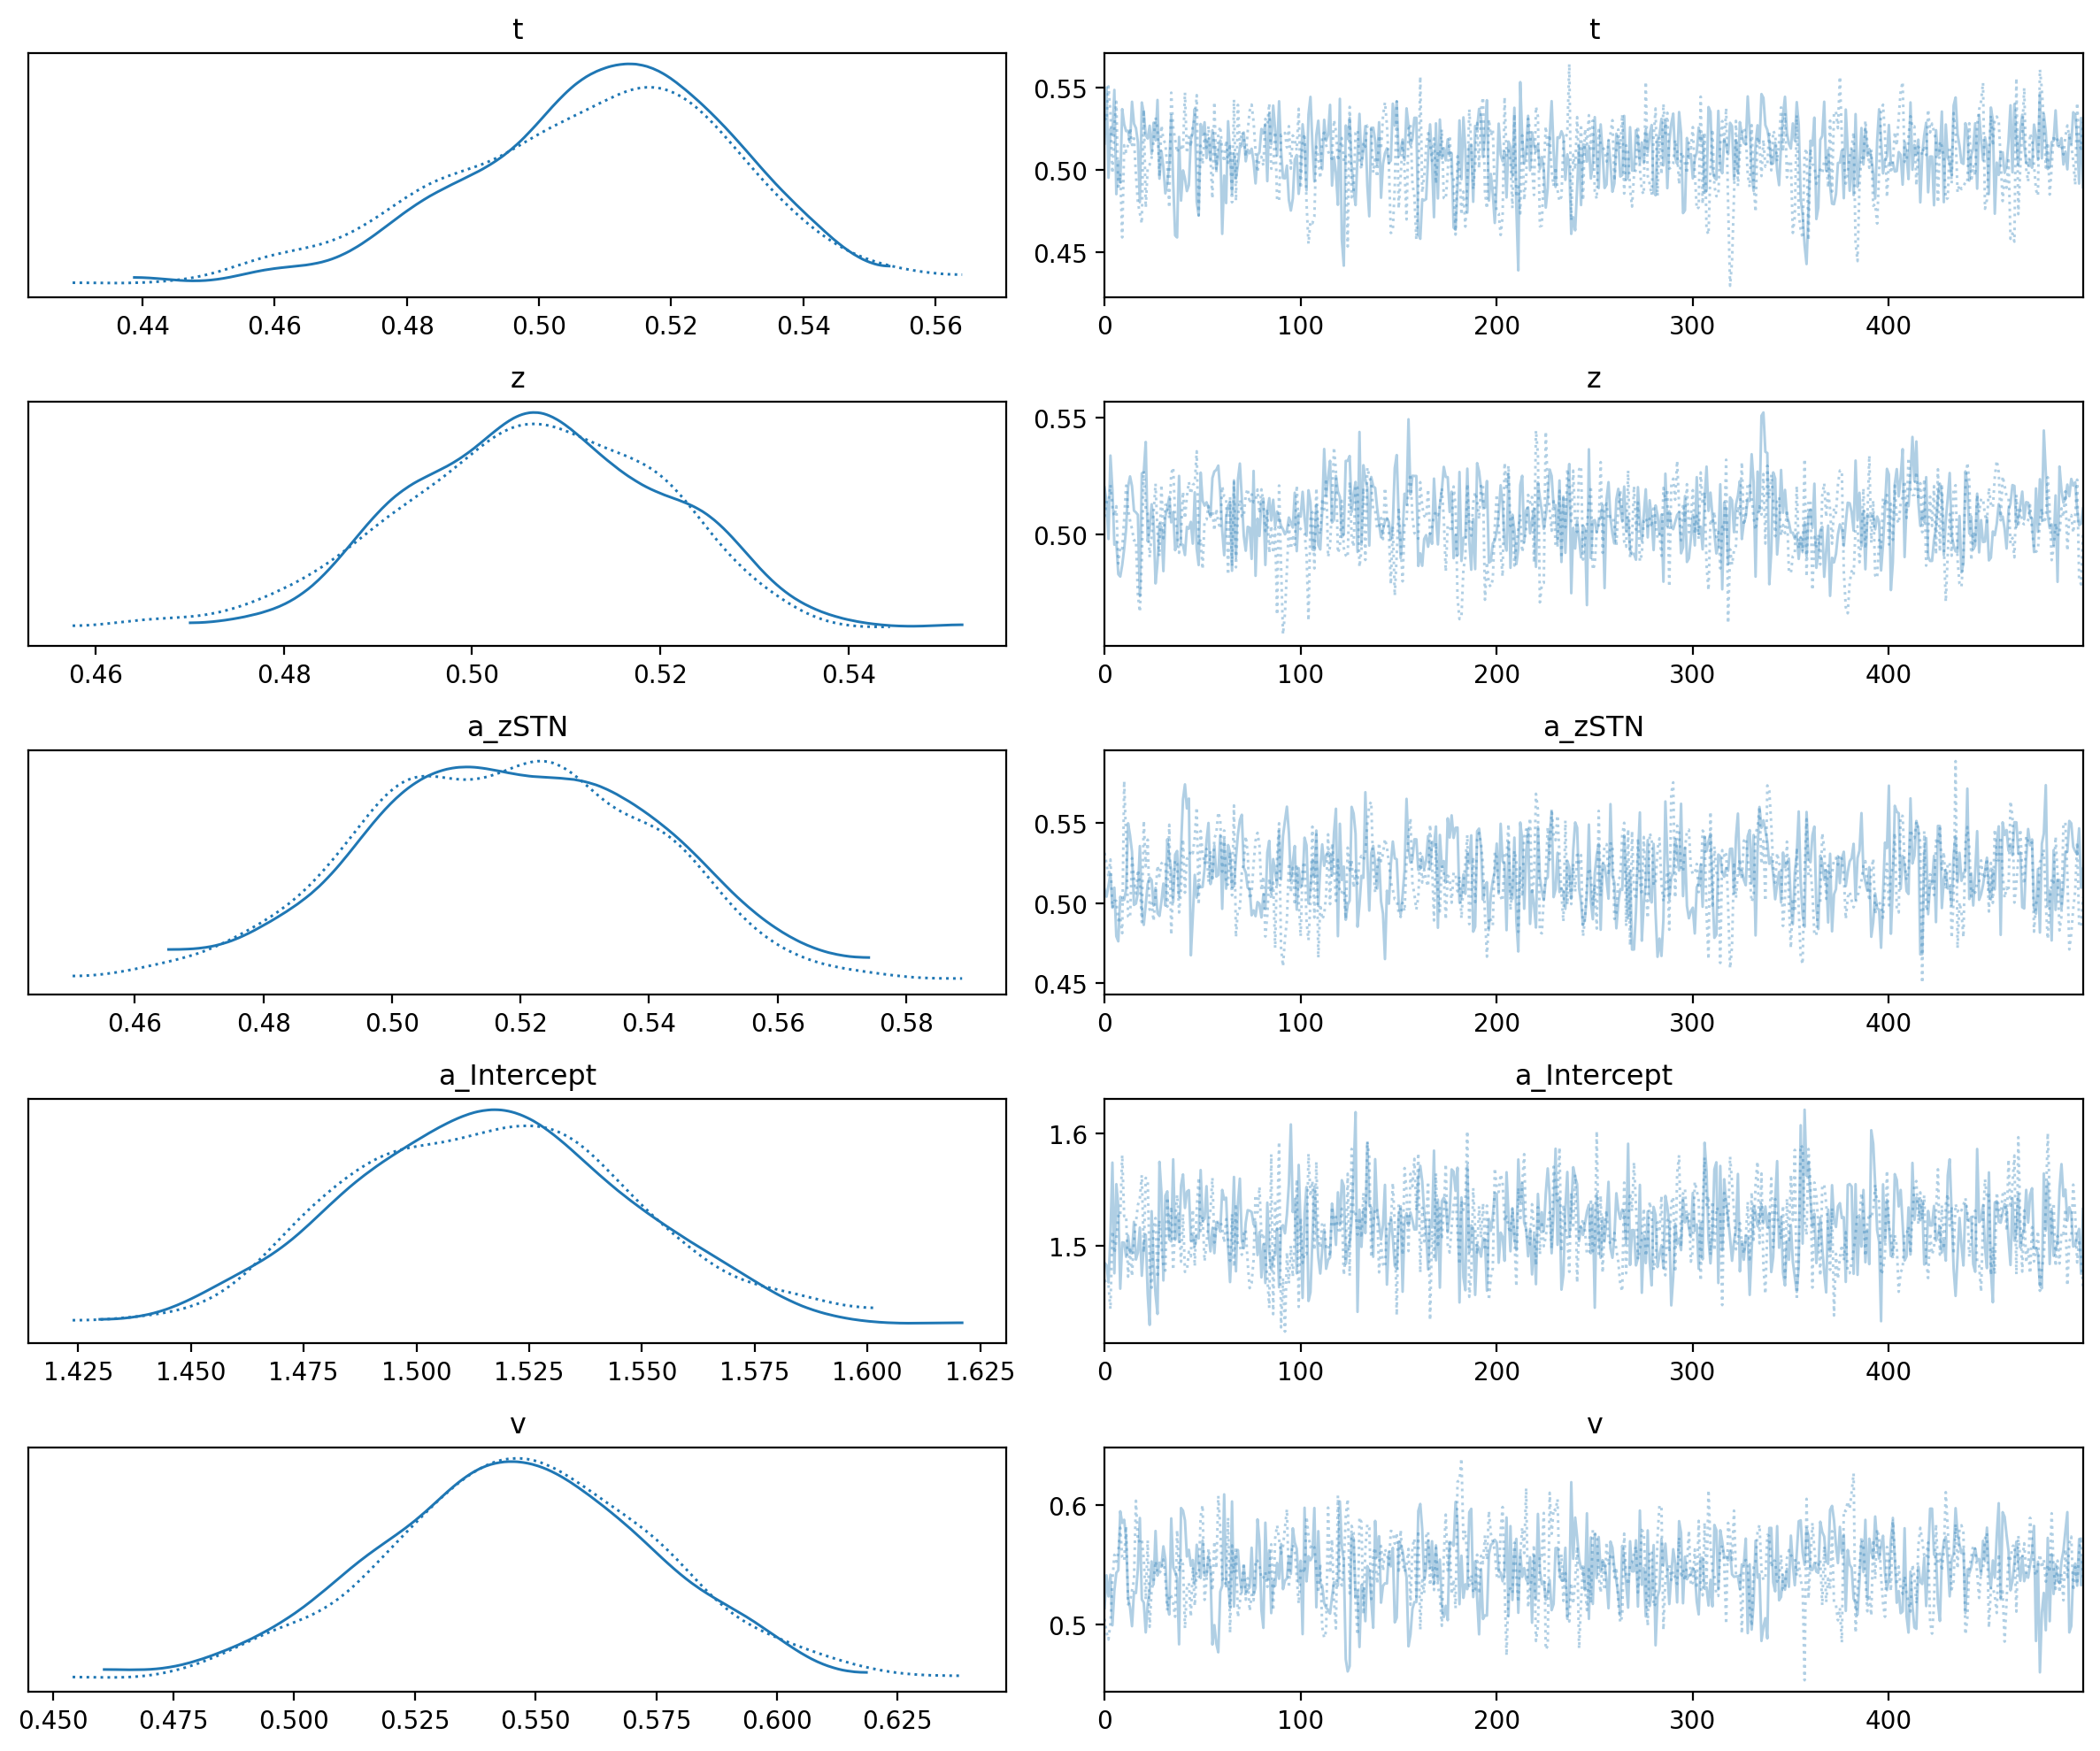

In [79]:
#### trace plots
model_ddm_reg_case1.plot_trace();

### Case Study 2: Participant hierarchy on two within-subject coefficients

- besides from STN, we also have an indirect nogo pathway via GPe
- this time, we want to assume that activity in these components modulates drift rate
- even though there is evidence that STN modulates the boundary, we always want to check different model specifications

#### Step 1: Regression-based data simulation (multiple subjects)

In [80]:
# Function to simulate data for one participant
def simulate_participant(participant_id, size=300):
    intercept = 1.5
    zSTN = np.random.normal(loc=1, scale=2, size=size)
    zGPe = np.random.normal(loc=1, scale=2, size=size)
    v = intercept + 0.8 * zSTN + 0.3 * zGPe

    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack(
        [v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=300)]
    )

    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )

    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = str(participant_id)
    return dataset_reg_v


# Simulate data for 10 participants

# Combine datasets into one DataFrame
combined_dataset = pd.concat(
    [simulate_participant(i, size=300) for i in range(1, 11)], ignore_index=True
)
combined_dataset

rt  response      zSTN      zGPe participant_id
0     1.280871       1.0  0.851466 -2.818660              1
1     1.338707       1.0  0.008094  1.254727              1
2     0.827624       1.0  0.892344  2.773173              1
3     1.224458       1.0  3.908126  1.674779              1
4     0.783313       1.0  3.571661  0.838951              1
...        ...       ...       ...       ...            ...
2995  1.299362      -1.0 -2.218223 -4.054360             10
2996  2.183317       1.0 -0.109671  0.244783             10
2997  1.006327       1.0  0.268048  3.415423             10
2998  2.929376       1.0 -1.537712  0.608413             10
2999  1.878767      -1.0 -2.846485  1.423902             10

[3000 rows x 5 columns]

#### Step 2: Model Setup & Priors

##### Alternative 1: A centered model
- specification where the subject-specific coefficients are coming from one hierarchical prior (mother distribution with mu and sigma)
- we can also call it as "0+" models
- this is the specification used in HDDM
- in this case, it's important to set "noncentered=False" (by default it's set to "True")
- The group distributions here will be recovered as v_1|subject_mu and v_x|subject_mu

In [81]:
model_reg_v_ex2_A1 = hssm.HSSM(
    data=combined_dataset,
    model="ddm",
    include=[
        {
            "name": "v",
            "formula": "v ~ 0 + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                "1|participant_id": {
                    "name": "Normal",
                    "mu": {"name": "Normal", "mu": 1, "sigma": 1.0, "initval": 0},
                    "sigma": {"name": "HalfNormal", "sigma": 1, "initval": 0.25},
                },
                "zSTN|participant_id": {
                    "name": "Normal",
                    "mu": {"name": "Normal", "mu": 0, "sigma": 1.0, "initval": 0},
                    "sigma": {"name": "HalfNormal", "sigma": 1, "initval": 0.25},
                },
                "zGPe|participant_id": {
                    "name": "Normal",
                    "mu": {"name": "Normal", "mu": 0, "sigma": 1.0, "initval": 0},
                    "sigma": {"name": "HalfNormal", "sigma": 1, "initval": 0.25},
                },
            },
            "link": "identity",
        }
    ],
    noncentered=False,
    p_outlier=0.05,
)

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3000

Parameters:

v:
    Formula: v ~ 0 + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_1|participant_id ~ Normal(mu: Normal(mu: 1.0, sigma: 1.0, initval: 0.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
        v_zSTN|participant_id ~ Normal(mu: Normal(mu: 0.0, sigma: 1.0, initval: 0.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
        v_zGPe|participant_id ~ Normal(mu: Normal(mu: 0.0, sigma: 1.0, initval: 0.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

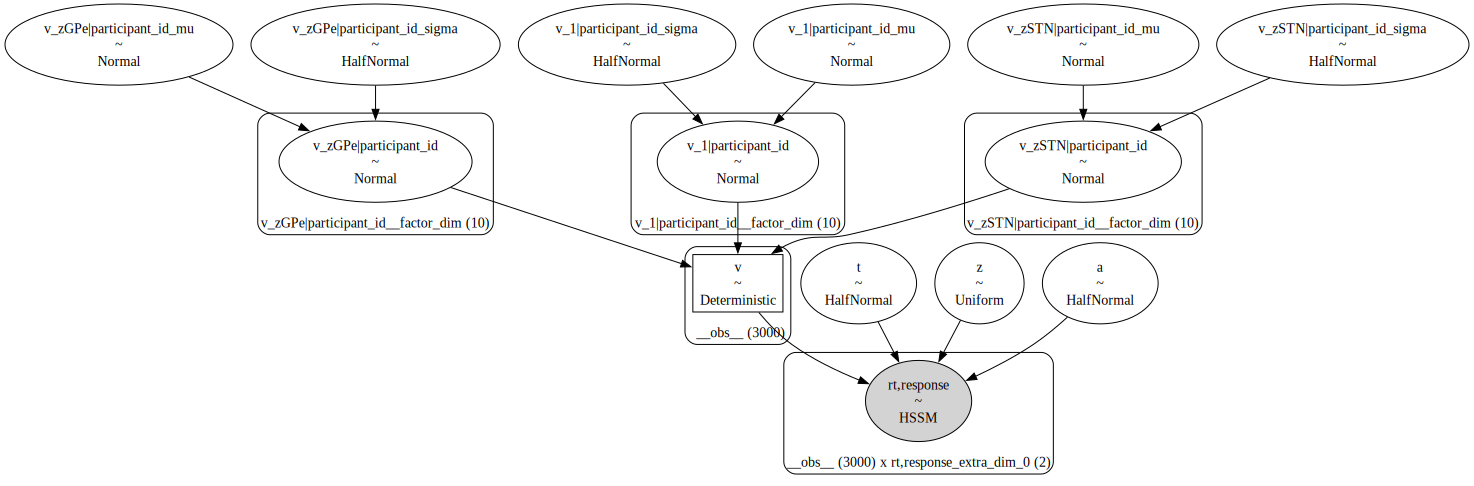

In [82]:
# graphical illustration of model
model_reg_v_ex2_A1.graph()

##### Alternative 2: A non-centered model
- Non-centered means that each subject is estimated as offset from the group mean
- in this case the group means will be zSTN and zGPe.
- The priors are different here because now we want the mu for the random subject effects to be 0
- the mu should not be estimated from a hyperprior simultaneously with the fixed effects, as those will tradeoff and could produce convergence issues  - we still estimate the sigmas with a hyperprior to allow us to get indiv params
- now we keep noncentered=true.

In [83]:
model_reg_v_ex2_A2 = hssm.HSSM(
    data=combined_dataset,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + zSTN + zGPe + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 1.0, "sigma": 1.0},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "1|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
                "zSTN|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
                "zGPe|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
            },
            "link": "identity",
        }
    ],
    noncentered=True,
    p_outlier=0.05,
)

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3000

Parameters:

v:
    Formula: v ~ 1 + zSTN + zGPe + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        v_zSTN ~ Normal(mu: 0.0, sigma: 1.0)
        v_zGPe ~ Normal(mu: 0.0, sigma: 1.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zSTN|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zGPe|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

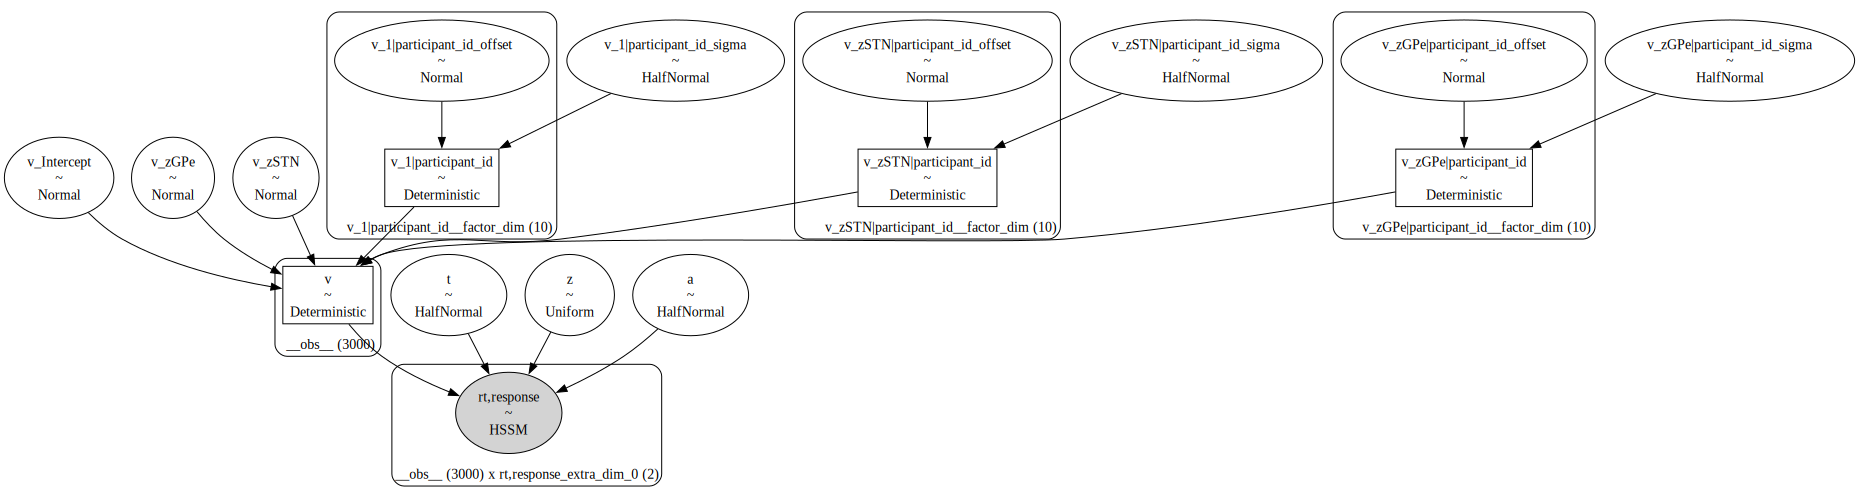

In [84]:
model_reg_v_ex2_A2.graph()

### Important note
Note that in this non-centered model, you will need to specify each individual coefficient's prior (at least for your regression equation). See example below

#### Step 4: Sampling from the Posterior Distribution (Bayesian Model Fitting based on MCMC Procedure)

In [85]:
## centered model version
samples_model_reg_v_ex2_A1 = model_reg_v_ex2_A1.sample(
    sampler="nuts_numpyro",
    cores=3,
    chains=3,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1500/1500 [00:01<00:00, 845.05it/s]


In [86]:
## centered model version
samples_model_reg_v_ex2_A2 = model_reg_v_ex2_A2.sample(
    sampler="nuts_numpyro",
    cores=3,
    chains=3,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1500/1500 [00:02<00:00, 704.70it/s]


#### Final notes:
- whether centered is better depends on the structure of your dataset
- the two models are mathematically equivalent, however the posterior geometry is affected by the parameterization
- in practice, you can try both and see which one works better
- [here](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html) is a great (albeit non-trivial to digest) long blog post which touches on the topic in some detail`

#### Step 5: Model Validation

In [87]:
#### posterior statistics of centered model
model_reg_v_ex2_A1.summary(var_names=["~_id"], filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
t  0.498  0.006   0.488    0.511      0.001    0.000     113.0     200.0   
z  0.486  0.011   0.463    0.504      0.002    0.002      31.0     482.0   
a  1.487  0.028   1.428    1.533      0.006    0.004      22.0     172.0   

   r_hat  
t   1.06  
z   1.07  
a   1.13

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


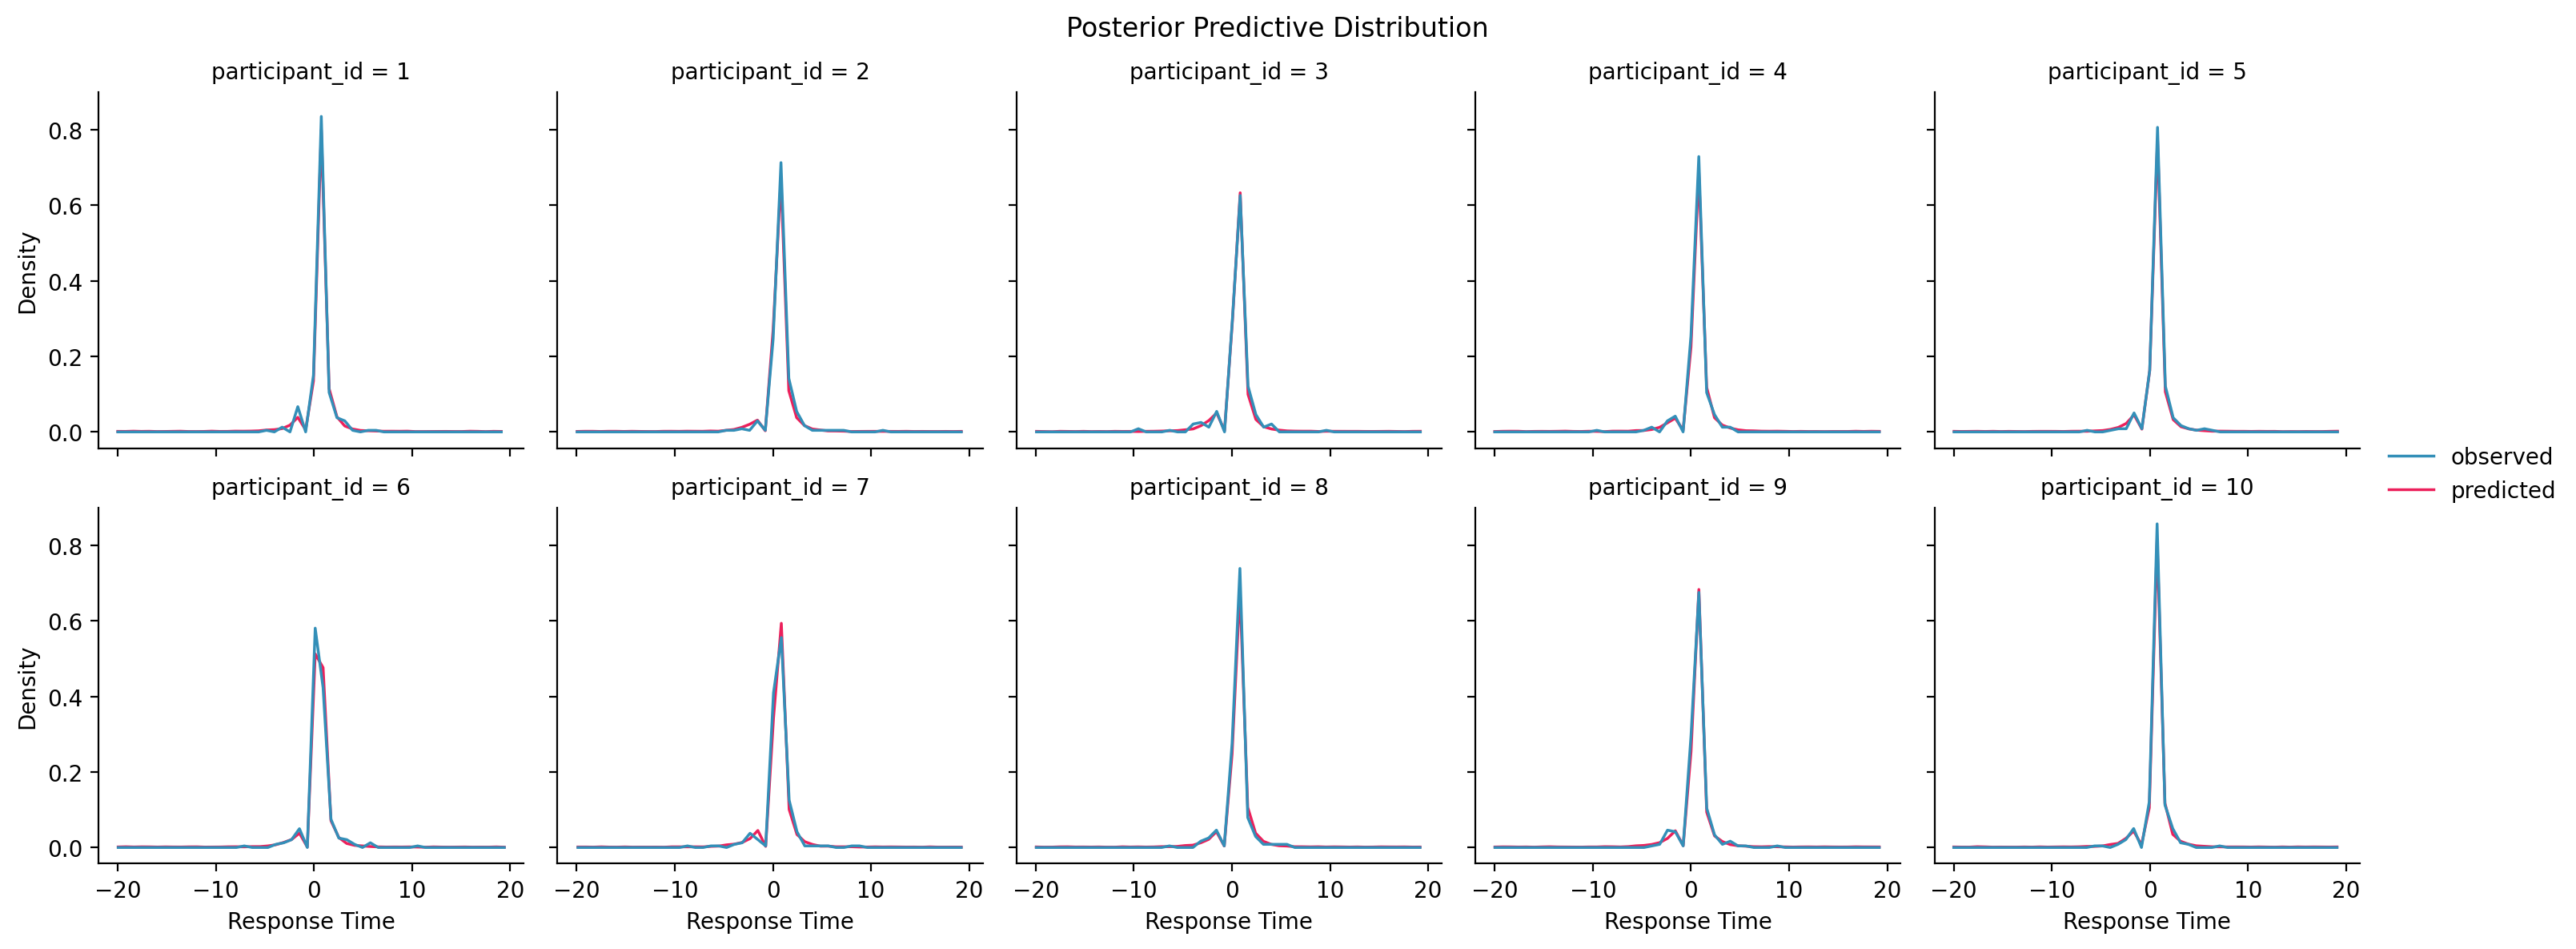

In [88]:
# Plotting the posterior predictive
hssm.plotting.plot_posterior_predictive(
    model_reg_v_ex2_A1, col="participant_id", col_wrap=5
)

In [89]:
#### posterior statistics of non-centered model
model_reg_v_ex2_A2.summary(var_names=["~_offset"], filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                  1.538  0.041   1.466    1.620      0.001   
v_zGPe|participant_id[1]     0.027  0.029  -0.014    0.085      0.001   
v_zGPe|participant_id[10]   -0.007  0.023  -0.056    0.036      0.001   
v_zGPe|participant_id[2]    -0.023  0.026  -0.076    0.017      0.001   
v_zGPe|participant_id[3]     0.011  0.025  -0.036    0.064      0.001   
v_zGPe|participant_id[4]     0.015  0.025  -0.024    0.069      0.001   
v_zGPe|participant_id[5]    -0.022  0.026  -0.074    0.022      0.001   
v_zGPe|participant_id[6]     0.005  0.022  -0.038    0.047      0.001   
v_zGPe|participant_id[7]     0.001  0.023  -0.044    0.047      0.001   
v_zGPe|participant_id[8]     0.006  0.023  -0.038    0.052      0.001   
v_zGPe|participant_id[9]    -0.012  0.024  -0.062    0.030      0.001   
v_zGPe                       0.294  0.016   0.266    0.324      0.000   
v_1|participant_id_sigma     0.033  0.027   0.000    0.081      0.001   
t                            0.499  0.006   0.487    0.510      0.000   
z                            0.483  0.011   0.464    0.507      0.000   
v_zGPe|participant_id_sigma  0.028  0.018   0.000    0.058      0.001   
v_zSTN                       0.815  0.018   0.781    0.849      0.001   
a                            1.478  0.026   1.429    1.526      0.001   
v_1|participant_id[1]        0.006  0.033  -0.056    0.071      0.001   
v_1|participant_id[10]       0.015  0.034  -0.040    0.089      0.001   
v_1|participant_id[2]       -0.011  0.034  -0.078    0.053      0.001   
v_1|participant_id[3]       -0.018  0.035  -0.095    0.037      0.001   
v_1|participant_id[4]        0.013  0.034  -0.048    0.085      0.001   
v_1|participant_id[5]       -0.004  0.033  -0.074    0.060      0.001   
v_1|participant_id[6]        0.002  0.034  -0.067    0.065      0.001   
v_1|participant_id[7]        0.005  0.033  -0.052    0.079      0.001   
v_1|participant_id[8]        0.005  0.036  -0.056    0.083      0.001   
v_1|participant_id[9]       -0.012  0.034  -0.081    0.047      0.001   
v_zSTN|participant_id_sigma  0.021  0.016   0.000    0.049      0.001   
v_zSTN|participant_id[1]    -0.012  0.023  -0.059    0.024      0.001   
v_zSTN|participant_id[10]    0.003  0.019  -0.033    0.044      0.000   
v_zSTN|participant_id[2]     0.004  0.020  -0.033    0.045      0.000   
v_zSTN|participant_id[3]     0.007  0.020  -0.030    0.050      0.001   
v_zSTN|participant_id[4]    -0.005  0.019  -0.046    0.032      0.001   
v_zSTN|participant_id[5]    -0.013  0.022  -0.061    0.020      0.001   
v_zSTN|participant_id[6]     0.001  0.020  -0.036    0.043      0.001   
v_zSTN|participant_id[7]     0.012  0.022  -0.020    0.064      0.001   
v_zSTN|participant_id[8]    -0.004  0.019  -0.042    0.033      0.000   
v_zSTN|participant_id[9]     0.009  0.021  -0.024    0.054      0.001   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                    0.001     887.0    1052.0   1.00  
v_zGPe|participant_id[1]       0.001     881.0    1198.0   1.00  
v_zGPe|participant_id[10]      0.001    1343.0    1122.0   1.00  
v_zGPe|participant_id[2]       0.001     795.0    1272.0   1.00  
v_zGPe|participant_id[3]       0.001    1570.0    1159.0   1.01  
v_zGPe|participant_id[4]       0.001    1106.0    1078.0   1.00  
v_zGPe|participant_id[5]       0.001     763.0    1023.0   1.00  
v_zGPe|participant_id[6]       0.001    1736.0    1410.0   1.00  
v_zGPe|participant_id[7]       0.001    1874.0    1300.0   1.00  
v_zGPe|participant_id[8]       0.000    1561.0    1413.0   1.00  
v_zGPe|participant_id[9]       0.001    1411.0    1310.0   1.00  
v_zGPe                         0.000    1061.0     818.0   1.00  
v_1|participant_id_sigma       0.001     853.0    1005.0   1.00  
t                              0.000    1205.0    1000.0   1.00  
z                              0.000    1192.0     965.0   1.00  
v_zGPe|participant_id_sigma    0.001     416.0     59

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


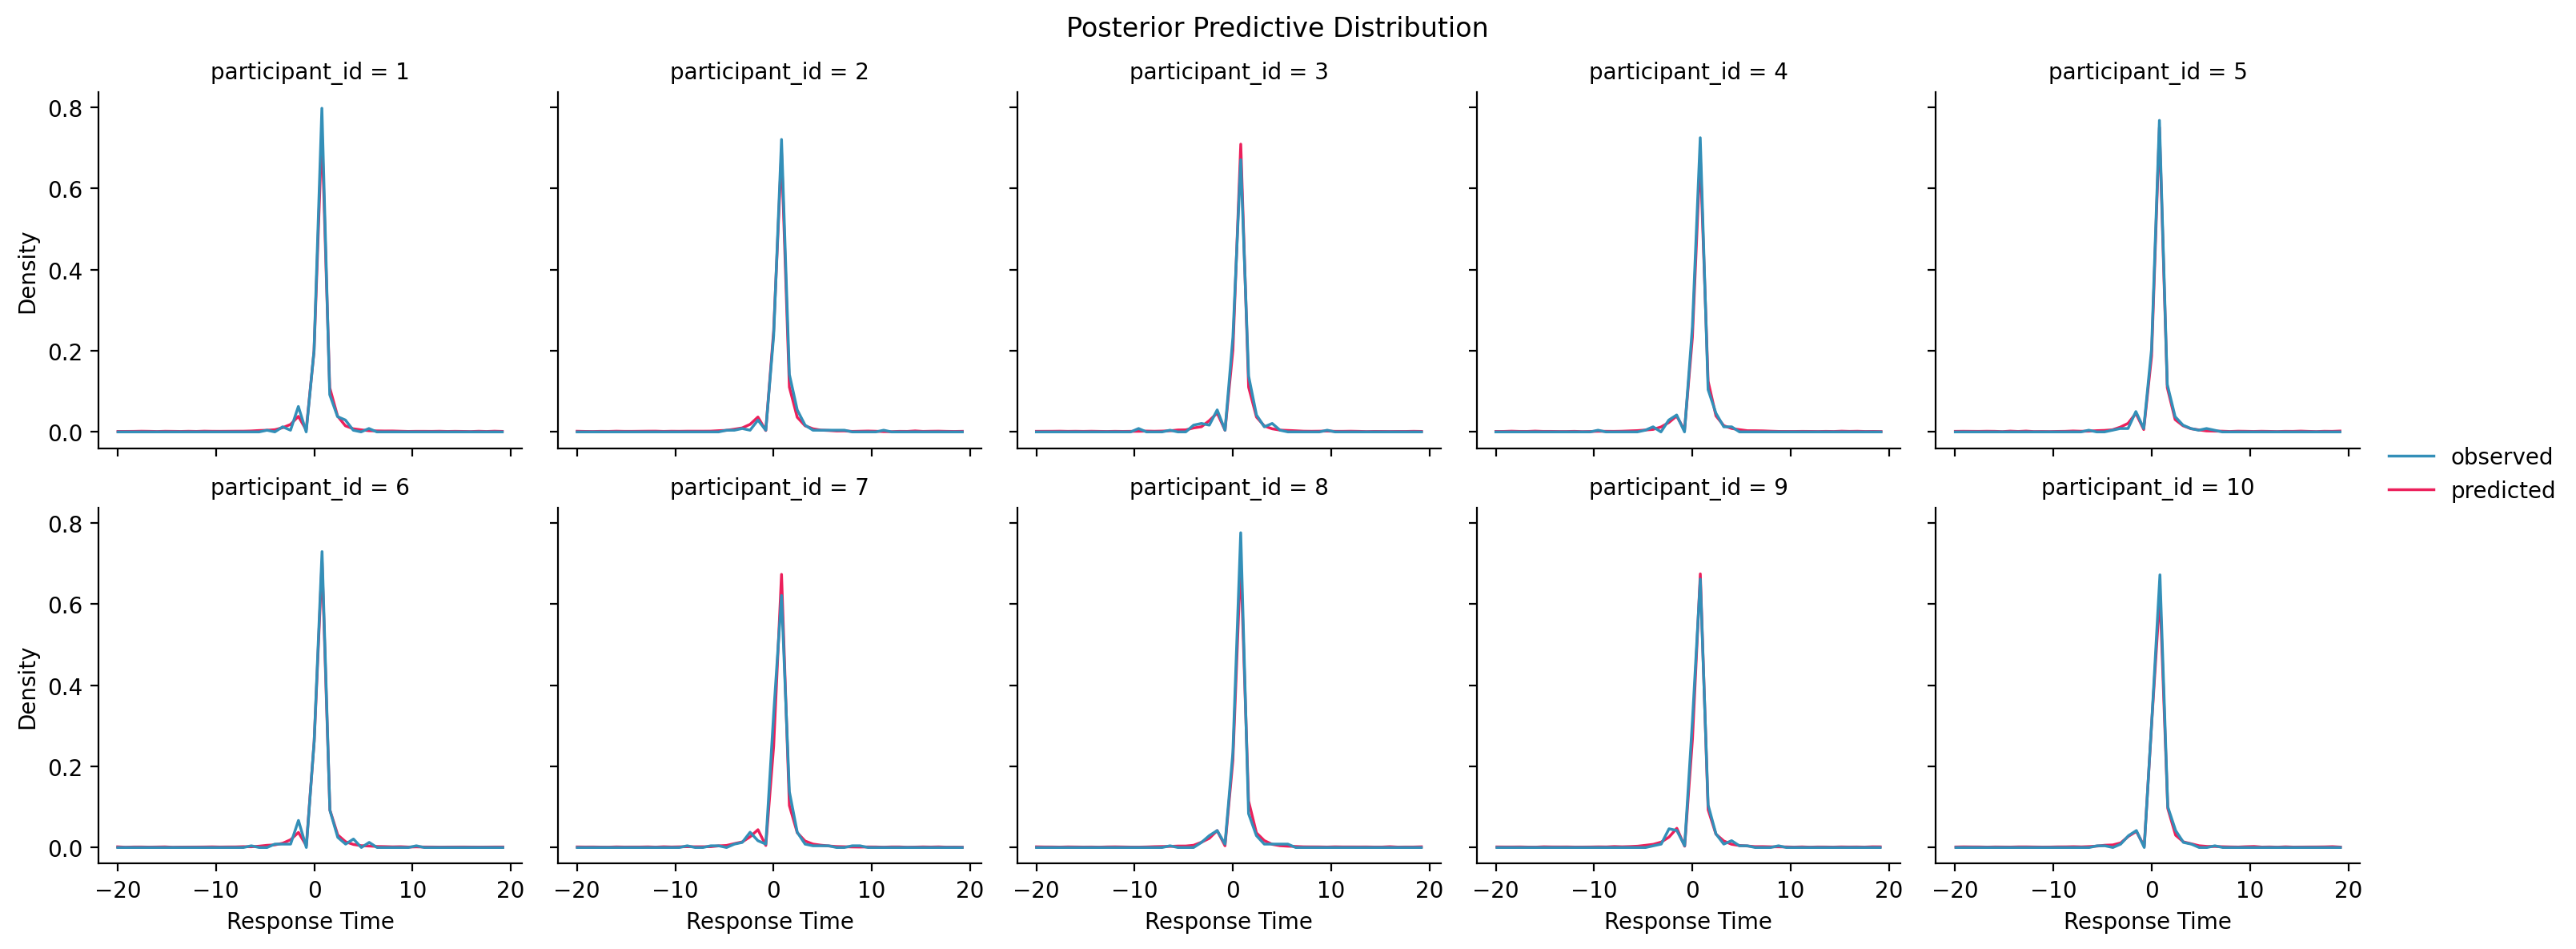

In [90]:
# Plotting the posterior predictive
hssm.plotting.plot_posterior_predictive(
    model_reg_v_ex2_A2, col="participant_id", col_wrap=5
)

# Additional Case studies (between-subject & group variables)

### Case Study 3: Participant-level hierarchy,  two within-subject coefficients and one between-subject coefficient

- we still have the intracranial recordings
- but now you have different patients and they vary in symptom severity for Parkinson
- you wonder whether those with higher symptom severity have a lower drift rate because the modulation from STN is less efficient

#### Step 1: Regression-based data simulation (multiple subjects)

In [91]:
# Function to simulate data for one participant
def simulate_participant2(participant_id, sevScore, size=300):
    intercept = 0.5
    zSTN = np.random.normal(loc=1, scale=2, size=size)
    zGPe = np.random.normal(loc=1, scale=2, size=size)

    ## Strength of neural modulation depends on PD severity score

    #### Case 1: only the interaction btw sevScore & STN/GPe will turn out sign, the main effects of STN & GPe will disappear
    # v = intercept + 0.8 * zSTN * sevScore + 0.3 * zGPe * sevScore

    #### Case 2: main effects of STN/GPe will remain, plus a significant interaction, but no modulation on intercept
    if sevScore < 0.2:
        v = intercept + 0.8 * zSTN + 0.3 * zGPe
    elif sevScore >= 0.2 and sevScore < 0.4:
        v = intercept + 0.7 * zSTN + 0.25 * zGPe
    elif sevScore >= 0.4 and sevScore < 0.6:
        v = intercept + 0.6 * zSTN + 0.2 * zGPe
    elif sevScore >= 0.6 and sevScore < 0.8:
        v = intercept + 0.5 * zSTN + 0.15 * zGPe
    else:
        v = intercept + 0.4 * zSTN + 0.1 * zGPe

    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack(
        [v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=size)]
    )
    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )

    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = str(participant_id)
    dataset_reg_v["sevScore"] = sevScore
    return dataset_reg_v


# Simulate data for four participants
### note that we assume that STN & GPe

# patients with severity scores
subj_list = [1, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8]
sevscore_list = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]

# Combine datasets into one DataFrame
combined_dataset2 = pd.concat(
    [
        simulate_participant2(subj, sevscore)
        for subj, sevscore in zip(subj_list, sevscore_list)
    ],
    ignore_index=True,
)
combined_dataset2

rt  response      zSTN      zGPe participant_id  sevScore
0     1.158008       1.0 -0.881464  2.870271              1       0.0
1     0.886376       1.0  4.203513  1.580031              1       0.0
2     0.990652       1.0  3.064582  0.920301              1       0.0
3     0.998088       1.0  2.655949  1.267802              1       0.0
4     1.628673       1.0  0.968137 -0.848018              1       0.0
...        ...       ...       ...       ...            ...       ...
3295  1.361452       1.0  3.671557 -0.752880              8       1.0
3296  1.022262       1.0  4.033932  0.788325              8       1.0
3297  1.167423       1.0  3.281838 -1.008586              8       1.0
3298  4.083560       1.0 -1.072045  3.363209              8       1.0
3299  1.108116       1.0 -1.233768 -1.161701              8       1.0

[3300 rows x 6 columns]

#### Step 2: Model Setup & Priors

In [92]:
model_reg_v_ex3_A1 = hssm.HSSM(
    data=combined_dataset2,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 1.0},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "1|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
                "zSTN|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
                "zGPe|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1.0},
                },
            },
            "link": "identity",
        }
    ],
    noncentered=True,
    p_outlier=0.05,
)

Model initialized successfully.


In [93]:
samples_model_reg_v_ex3_A1 = model_reg_v_ex3_A1.sample(
    sampler="nuts_numpyro",
    cores=3,
    chains=3,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1500/1500 [00:02<00:00, 684.65it/s]


In [94]:
#### posterior statistics of non-centered model
model_reg_v_ex3_A1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_zGPe:sevScore                 -0.227  0.039  -0.303   -0.158      0.002   
v_Intercept                      0.605  0.052   0.506    0.698      0.002   
v_zGPe                           0.300  0.023   0.255    0.341      0.001   
v_1|participant_id_sigma         0.045  0.038   0.000    0.112      0.002   
t                                0.500  0.008   0.485    0.514      0.000   
z                                0.484  0.008   0.470    0.500      0.000   
v_zGPe|participant_id_sigma      0.017  0.014   0.000    0.040      0.001   
v_zSTN                           0.763  0.073   0.603    0.868      0.006   
a                                1.507  0.020   1.468    1.544      0.000   
v_zSTN:sevScore                 -0.336  0.156  -0.532   -0.024      0.014   
v_zSTN|participant_id_sigma      0.056  0.053   0.000    0.158      0.005   
v_1|participant_id_offset[1]     0.025  0.861  -1.597    1.587      0.021   
v_1|participant_id_offset[2]    -0.156  0.868  -1.883    1.394      0.022   
v_1|participant_id_offset[3]     0.308  0.820  -1.196    1.872      0.021   
v_1|participant_id_offset[4]    -0.127  0.839  -1.657    1.462      0.022   
v_1|participant_id_offset[5]     0.486  0.849  -1.103    2.135      0.021   
v_1|participant_id_offset[6]    -0.688  0.887  -2.317    1.036      0.023   
v_1|participant_id_offset[7]    -0.053  0.901  -1.885    1.454      0.027   
v_1|participant_id_offset[8]     0.279  0.892  -1.556    1.768      0.028   
v_zGPe|participant_id_offset[1] -0.247  0.900  -1.835    1.469      0.026   
v_zGPe|participant_id_offset[2] -0.120  0.909  -1.653    1.926      0.041   
v_zGPe|participant_id_offset[3]  0.540  0.965  -1.155    2.404      0.026   
v_zGPe|participant_id_offset[4] -0.159  0.894  -1.743    1.616      0.037   
v_zGPe|participant_id_offset[5]  0.283  0.901  -1.447    1.880      0.031   
v_zGPe|participant_id_offset[6] -0.021  0.898  -1.684    1.652      0.023   
v_zGPe|participant_id_offset[7] -0.281  0.909  -2.068    1.361      0.034   
v_zGPe|participant_id_offset[8] -0.165  0.926  -1.858    1.602      0.028   
v_zSTN|participant_id_offset[1]  0.884  0.833  -0.592    2.539      0.029   
v_zSTN|participant_id_offset[2]  0.089  0.753  -1.337    1.560      0.024   
v_zSTN|participant_id_offset[3] -0.100  0.726  -1.559    1.197      0.025   
v_zSTN|participant_id_offset[4]  0.014  0.716  -1.471    1.306      0.020   
v_zSTN|participant_id_offset[5]  0.015  0.693  -1.121    1.451      0.019   
v_zSTN|participant_id_offset[6] -0.255  0.729  -1.608    1.128      0.024   
v_zSTN|participant_id_offset[7]  0.421  0.801  -0.984    1.921      0.037   
v_zSTN|participant_id_offset[8] -1.104  0.855  -2.702    0.560      0.032   
v_sevScore                      -0.099  0.086  -0.263    0.052      0.003   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
v_zGPe:sevScore                    0.001     582.0     482.0   1.00  
v_Intercept                        0.001     793.0     759.0   1.00  
v_zGPe                             0.001     662.0     652.0   1.00  
v_1|participant_id_sigma           0.002     341.0     232.0   1.01  
t                                  0.000    1476.0    1039.0   1.01  
z                                  0.000    1518.0    1220.0   1.01  
v_zGPe|participant_id_sigma        0.000     416.0     727.0   1.00  
v_zSTN                             0.004     228.0     103.0   1.00  
a                                  0.000    1736.0    1156.0   1.00  
v_zSTN:sevScore                    0.010     193.0     103.0   1.01  
v_zSTN|participant_id_sigma        0.004     179.0     114.0   1.01  
v_1|participant_id_offset[1]       0.025    1638.0    1039.0   1.00  
v_1|participant_id_offset[2]       0.023    1509.0    1059.0   1.00  
v_1|participant_id_offset[3]       0.020    1497.0    1043.0   1.01  
v_1|participant_id_offset[4]       0.023    1448.0     906.0   1.00  
v_1|participant_id_offset[5]       0.018    1636.0     992.0   1

- there is no main effect of severity (makes sense because we didn't change the intercept by severity!)
- you can see that by looking at the credible interval (hdi's). They are interpret similar to confidence intervals
- the intercept itself is recovered well (input: 0.5)
- the effect of severity onto STN is significant. This is good because we did manipulate that (0.6 was around the mean effect)

### Case Study 4: Two hierarchical layers (trial- and sbj-level) & Two within-sbj coefficients & one btw-sbj coefficient & group

- we still have the intracranial recordings
- but now you have different patients and they vary in symptom severity for Parkinson
- you wonder whether those with higher symptom severity have a lower drift rate because the modulation from STN is less efficient

BUT NOW: your friend is a clinician and tells you that some people might have Dystonia rather than Parkinson and they show different symptoms.
So, you want to take this into account now

##### Audience Question: how would you do that? How would you change the data simulation?

#### Step 1: Regression-based data simulation (multiple subjects)

In [95]:
# Function to simulate data for one participant
def simulate_participant3(participant_id, sevScore, diagnosis, size=300):
    # intercept = 0.5
    zSTN = np.random.normal(loc=1, scale=2, size=size)
    zGPe = np.random.normal(loc=1, scale=2, size=size)

    if diagnosis == "PD":
        intercept = 0.3
    else:
        intercept = 0.6

    ## Strength of neural modulation depends on PD severity score
    if sevScore <= 0.2:
        v = intercept + 0.8 * zSTN + 0.3 * zGPe
    elif sevScore > 0.2 and sevScore <= 0.4:
        v = intercept + 0.6 * zSTN + 0.2 * zGPe
    elif sevScore > 0.4 and sevScore < 0.6:
        v = intercept + 0.5 * zSTN + 0.1 * zGPe
    else:
        v = intercept + 0.4 * zSTN + 0.0 * zGPe

    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack(
        [v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=size)]
    )
    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )

    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = str(participant_id)
    dataset_reg_v["sevScore"] = sevScore
    dataset_reg_v["diagnosis"] = diagnosis

    return dataset_reg_v


# Simulate data for four participants
### note that we assume that STN & GPe

## PD patients:
# patients with low severity scores
subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8]
sevscore_list = [
    0.10,
    0.20,
    0.30,
    0.40,
    0.50,
    0.60,
    0.70,
    0.80,
    0.10,
    0.20,
    0.30,
    0.40,
    0.50,
    0.60,
    0.70,
    0.80,
]
diagnosis_list = [
    "PD",
    "PD",
    "PD",
    "PD",
    "PD",
    "PD",
    "PD",
    "PD",
    "DD",
    "DD",
    "DD",
    "DD",
    "DD",
    "DD",
    "DD",
    "DD",
]

# [simulate_participant3(subj, sevscore, diagnosis) for subj, sevscore, diagnosis in zip(subj_list, sevscore_list, diagnosis_list)]
# dataset2_participant1 = simulate_participant3(1,0.10,"PD")
# dataset2_participant2 = simulate_participant3(2,0.20,"PD")
# dataset2_participant3 = simulate_participant3(3,0.30,"PD")
# dataset2_participant4 = simulate_participant3(4,0.40,"PD")
# # patients with high severity scores
# dataset2_participant5 = simulate_participant3(5,0.50,"PD")
# dataset2_participant6 = simulate_participant3(6,0.60,"PD")
# dataset2_participant7 = simulate_participant3(7,0.70,"PD")
# dataset2_participant8 = simulate_participant3(8,0.80,"PD")

# ## Dystonia patients:
# # patients with low severity scores
# dataset2_participant9 = simulate_participant3(1,0.10,"DD")
# dataset2_participant10 = simulate_participant3(2,0.20,"DD")
# dataset2_participant11 = simulate_participant3(3,0.30,"DD")
# dataset2_participant12 = simulate_participant3(4,0.40,"DD")
# # patients with high severity scores
# dataset2_participant13 = simulate_participant3(5,0.50,"DD")
# dataset2_participant14 = simulate_participant3(6,0.60,"DD")
# dataset2_participant15 = simulate_participant3(7,0.70,"DD")
# dataset2_participant16 = simulate_participant3(8,0.80,"DD")

# Combine datasets into one DataFrame
combined_dataset3 = pd.concat(
    [
        simulate_participant3(subj, sevscore, diagnosis)
        for subj, sevscore, diagnosis in zip(subj_list, sevscore_list, diagnosis_list)
    ],
    ignore_index=True,
)
combined_dataset3

rt  response      zSTN      zGPe participant_id  sevScore  \
0     0.920093       1.0  1.460063  2.599932              1       0.1   
1     1.895956       1.0  0.528022  2.650326              1       0.1   
2     2.352382       1.0 -0.013171  1.096793              1       0.1   
3     3.713829       1.0  0.741769 -1.114357              1       0.1   
4     1.071956       1.0  1.857717  1.370395              1       0.1   
...        ...       ...       ...       ...            ...       ...   
4795  1.808623       1.0  1.677419  1.744093              8       0.8   
4796  0.964277       1.0  1.541400 -1.548762              8       0.8   
4797  0.952152       1.0  1.619092  1.205605              8       0.8   
4798  4.067556      -1.0 -0.271316  2.719653              8       0.8   
4799  1.668725       1.0  1.134164  2.763838              8       0.8   

     diagnosis  
0           PD  
1           PD  
2           PD  
3           PD  
4           PD  
...        ...  
4795        DD  
4796        DD  
4797        DD  
4798        DD  
4799        DD  

[4800 rows x 7 columns]

In [96]:
model_reg_v_ex4_A1 = hssm.HSSM(
    data=combined_dataset3,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + ((1 + zSTN + zGPe)|participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 1.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "1|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
                "zSTN|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
                "zGPe|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
            },
            "link": "identity",
        }
    ],
    noncentered=True,
    p_outlier=0.05,
)
model_reg_v_ex4_A1

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4800

Parameters:

v:
    Formula: v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + ((1 + zSTN + zGPe)|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 1.5, sigma: 1.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 1.0)
        v_zGPe ~ Normal(mu: 0.0, sigma: 1.0)
        v_sevScore ~ Normal(mu: 0.0, sigma: 1.0)
        v_zSTN:sevScore ~ Normal(mu: 0.0, sigma: 1.0)
        v_zGPe:sevScore ~ Normal(mu: 0.0, sigma: 1.0)
        v_C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v

In [97]:
samples_model_reg_v_ex4_A1 = model_reg_v_ex4_A1.sample(
    sampler="nuts_numpyro",
    cores=3,
    chains=3,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1500/1500 [00:03<00:00, 479.95it/s]


In [98]:
#### posterior statistics of non-centered model
model_reg_v_ex4_A1.summary(
    var_names=["~_offset", "~_id"], filter_vars="like"
)  # var_names= ["~_offset"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                       0.576  0.058   0.467    0.677      0.002   
v_zSTN:C(diagnosis)[PD]           0.014  0.038  -0.055    0.087      0.001   
v_zGPe:sevScore                  -0.612  0.083  -0.755   -0.446      0.003   
v_zGPe                            0.418  0.043   0.334    0.491      0.002   
v_zSTN                            0.868  0.064   0.741    0.981      0.003   
v_zSTN:sevScore:C(diagnosis)[PD] -0.002  0.069  -0.136    0.125      0.002   
v_zGPe:C(diagnosis)[PD]          -0.053  0.031  -0.112    0.005      0.001   
v_C(diagnosis)[PD]               -0.277  0.063  -0.392   -0.156      0.002   
t                                 0.509  0.006   0.497    0.519      0.000   
z                                 0.502  0.006   0.490    0.514      0.000   
v_zGPe:sevScore:C(diagnosis)[PD]  0.091  0.059  -0.015    0.202      0.002   
a                                 1.501  0.016   1.471    1.529      0.000   
v_zSTN:sevScore                  -0.648  0.125  -0.879   -0.402      0.005   
v_sevScore                        0.098  0.108  -0.120    0.281      0.004   
v_sevScore:C(diagnosis)[PD]      -0.051  0.118  -0.289    0.154      0.004   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                         0.001    1096.0    1319.0   1.00  
v_zSTN:C(diagnosis)[PD]             0.001    1044.0     993.0   1.00  
v_zGPe:sevScore                     0.002     620.0     669.0   1.00  
v_zGPe                              0.001     653.0     530.0   1.01  
v_zSTN                              0.002     616.0     617.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.002    1088.0     946.0   1.00  
v_zGPe:C(diagnosis)[PD]             0.001    1113.0    1052.0   1.00  
v_C(diagnosis)[PD]                  0.002     879.0    1035.0   1.00  
t                                   0.000    1724.0    1186.0   1.00  
z                                   0.000    2063.0    1284.0   1.00  
v_zGPe:sevScore:C(diagnosis)[PD]    0.001    1104.0    1087.0   1.00  
a                                   0.000    2140.0    1124.0   1.00  
v_zSTN:sevScore                     0.004     535.0     608.0   1.00  
v_sevScore                          0.003     897.0     878.0   1.00  
v_sevScore:C(diagnosis)[PD]         0.003     870.0     962.0   1.00

#### Other Example 2

In [99]:
model_reg_v_ex4_A2 = hssm.HSSM(
    data=combined_dataset3,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + ((1 + zSTN + zGPe)|participant_id/C(diagnosis))",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 1.0},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 1.0},
                "1|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
                "zSTN|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
                "zGPe|participant_id": {
                    "name": "Normal",
                    "mu": 0,
                    "sigma": {"name": "HalfNormal", "sigma": 1},
                },
            },
            "link": "identity",
        }
    ],
    noncentered=True,
    p_outlier=0.05,
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.


Model initialized successfully.


In [100]:
samples_model_reg_v_ex4_A2 = model_reg_v_ex4_A2.sample(
    sampler="nuts_numpyro",
    cores=3,
    chains=3,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1500/1500 [00:03<00:00, 425.24it/s]


In [101]:
#### posterior statistics of non-centered model
model_reg_v_ex4_A2.summary(var_names=["~_offset", "~_id"], filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept      0.442  0.116   0.218    0.656      0.005    0.003     611.0   
v_zGPe:sevScore -0.549  0.092  -0.714   -0.362      0.005    0.004     497.0   
v_zGPe           0.387  0.043   0.307    0.468      0.002    0.001     711.0   
v_zSTN           0.876  0.062   0.762    0.986      0.003    0.002     491.0   
t                0.509  0.006   0.497    0.520      0.000    0.000    1888.0   
z                0.501  0.006   0.491    0.515      0.000    0.000    2045.0   
a                1.500  0.016   1.473    1.531      0.000    0.000    1966.0   
v_zSTN:sevScore -0.651  0.120  -0.899   -0.450      0.005    0.004     541.0   
v_sevScore       0.067  0.225  -0.359    0.476      0.009    0.007     573.0   

                 ess_tail  r_hat  
v_Intercept         784.0   1.00  
v_zGPe:sevScore     137.0   1.01  
v_zGPe              673.0   1.00  
v_zSTN              705.0   1.01  
t                  1225.0   1.00  
z                  1137.0   1.00  
a                  1170.0   1.00  
v_zSTN:sevScore     613.0   1.01  
v_sevScore          785.0   1.01

## Comparison

In [102]:
az.compare(
    {"Model 1": samples_model_reg_v_ex4_A1, "Model 2": samples_model_reg_v_ex4_A2}
)

rank     elpd_loo      p_loo  elpd_diff  weight         se       dse  \
Model 1     0 -5474.694548  26.597726    0.00000     1.0  89.767316  0.000000   
Model 2     1 -5480.910478  36.499641    6.21593     0.0  89.848885  2.855761   

         warning scale  
Model 1    False   log  
Model 2    False   log